# Hessian Matrix example

In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
from pytao import Tao
import matplotlib.pyplot as plt
import numdifftools as nd
tkwargs = {
    "dtype" : torch.double
}
import time
import os
np.set_printoptions(precision= 15, suppress=False)
torch.set_printoptions(precision= 15, sci_mode=True)
import pytao
torch.__version__, np.__version__, pytao.__version__

('1.11.0', '1.22.4', '0.1.7')

In [2]:
# Particle bunch with Gaussian distribution
from bmadx import Particle, M_ELECTRON
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*M_ELECTRON # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
bunch_in = Particle(*sample.T, ts, tp0c, tmc2)

In [3]:
# consider beamsize after 10 quad lattice:

from bmadx import Drift, Quadrupole, track_a_lattice

L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(torch.tensor(L_d, **tkwargs))

def torch_quadrupole(L: torch.Tensor, K1: torch.Tensor, NUM_STEPS=1,
                     X_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                     Y_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                     TILT: torch.Tensor=torch.tensor(0.0,**tkwargs)):
    return Quadrupole(L=L, K1=K1, NUM_STEPS=NUM_STEPS, X_OFFSET=X_OFFSET,
                      Y_OFFSET=Y_OFFSET, TILT=TILT)

def sigmax_end(k1s):
    """returns x beamsize after lattice composed by len(k1s)+1 
    drifts with len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    
    for k1 in k1s:
        lattice.append(torch_quadrupole(L=torch.tensor(L_q, **tkwargs), K1=k1))
        lattice.append(drift)

    bunch_out = track_a_lattice(bunch_in, lattice)[-1]
    return torch.std(bunch_out.x)

k1s = torch.zeros(10, **tkwargs)

In [4]:
%%time
hessian_py = hessian(sigmax_end,k1s) #autodiff hessian
hessian_py

CPU times: user 2.99 s, sys: 509 ms, total: 3.5 s
Wall time: 8.09 s


tensor([[6.415543903475004e-05, 1.960704846669135e-04, 3.097159794816570e-04,
         3.890583261757321e-04, 4.340975247491387e-04, 4.448335752018771e-04,
         4.212664775339470e-04, 3.633962317453484e-04, 2.712228378360815e-04,
         1.447462958061462e-04],
        [1.960704846669134e-04, 4.201233641085949e-05, 2.924719227168476e-04,
         5.010570772717949e-04, 6.385578414700411e-04, 7.049742153115861e-04,
         7.003061987964299e-04, 6.245537919245726e-04, 4.777169946960141e-04,
         2.597958071107545e-04],
        [3.097159794816571e-04, 2.924719227168480e-04, 2.617337701813275e-05,
         3.612747424875974e-04, 6.276017616083615e-04, 7.860893128066057e-04,
         8.367373960823299e-04, 7.795460114355343e-04, 6.145151588662185e-04,
         3.416448383743828e-04],
        [3.890583261757321e-04, 5.010570772717951e-04, 3.612747424875971e-04,
         1.531040803086441e-05, 4.012292851640987e-04, 6.881788676869347e-04,
         8.305600693916459e-04, 8.283728902

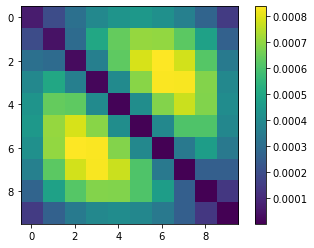

In [5]:
plt.imshow(hessian_py.detach().numpy())
plt.colorbar()

In [6]:
#Hessian using numerical differentiation

bunch_in_np = Particle(*sample.detach().numpy().T, 0, p0c, mc2)

L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(L_d)
def sigmax_end2(k1s):
    """returns x beamsize after lattice composed by len(k1s)+1 
    drifts with len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    
    for k1 in k1s:
        lattice.append(Quadrupole(L=L_q, K1=k1))
        lattice.append(drift)

    bunch_out = track_a_lattice(bunch_in_np, lattice)[-1]
    
    return np.std(bunch_out.x)

#k1s = np.array([10,-10,10,-10,10,-10,10,-10,10,-10])
k1s = np.zeros(10)

In [7]:
%%time
hessian_nd = nd.Hessian(sigmax_end2)(k1s) # numerical diff hessian
hessian_nd

CPU times: user 1min 26s, sys: 311 ms, total: 1min 27s
Wall time: 1min 27s


array([[6.960594398725643e-05, 2.184986499561333e-04,
        3.370625229115767e-04, 4.196806349661277e-04,
        4.663529861191750e-04, 4.770795763697534e-04,
        4.518604057197038e-04, 3.906954741653978e-04,
        2.935847817093453e-04, 1.605283283510263e-04],
       [2.184986499561333e-04, 5.186341846299550e-05,
        3.263614450458664e-04, 5.381577152468842e-04,
        6.772453775373498e-04, 7.436244319066743e-04,
        7.372948783637631e-04, 6.582567169072259e-04,
        5.065099475318093e-04, 2.820545702416532e-04],
       [3.370625229115767e-04, 3.263614450458664e-04,
        3.931538312020879e-05, 4.033198995662425e-04,
        6.711693753887885e-04, 8.295735478731985e-04,
        8.785324170158666e-04, 8.180459828109866e-04,
        6.481142452620941e-04, 3.687372043709181e-04],
       [4.196806349661277e-04, 5.381577152468842e-04,
        4.033198995662425e-04, 3.063434940296433e-05,
        4.481249796789754e-04, 7.349269242624926e-04,
        8.755730216751835

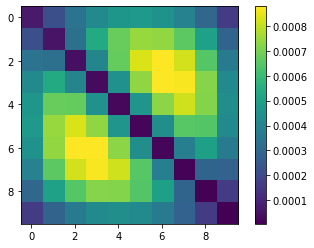

In [8]:
plt.imshow(hessian_nd)
plt.colorbar()

In [9]:
# not equal since numerical differentiation is innacurate
np.allclose(hessian_nd, hessian_py.detach().numpy())

False

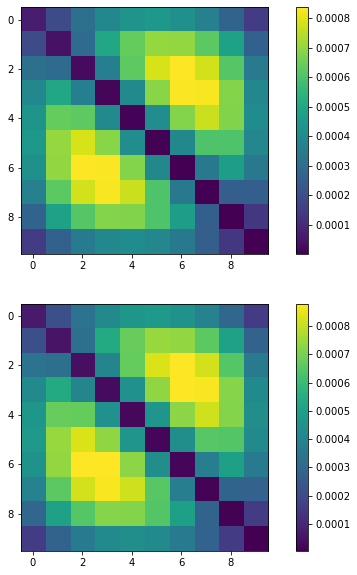

In [10]:
# but they are very close:
fig, axs = plt.subplots(2, figsize=(10,10))
cm = axs[0].imshow(hessian_py.detach().numpy())
fig.colorbar(cm,ax=axs[0])
cm = axs[1].imshow(hessian_nd)
fig.colorbar(cm,ax=axs[1])